# Image classification model training

In this notebook, we will use Tensorflow to train a model to classify images from the [Intel images dataset](https://www.kaggle.com/puneet6060/intel-image-classification). We will train a simple CNN custom model and then use transfer learning to fine-tune a pre-trained model (MobileNetV2).

## Imports and data generators

Mount Google Drive to access the dataset and save the model.

In [3]:
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Unzip the dataset.

In [4]:
%%capture
!unzip '/content/drive/MyDrive/intel-image-dataset.zip'

Import the necessary libraries.

In [5]:
import os
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2

Define the paths to the training and test datasets

In [6]:
train_path = './seg_train/seg_train/'
test_path = './seg_test/seg_test/'

Read data from the training and test directories.

In [7]:
train_dict = {}
test_dict = {}

for i in os.listdir(train_path):
    train_dict[i] = os.path.join(train_path, i)
for i in os.listdir(test_path):
    test_dict[i] = os.path.join(test_path, i)

Define a function to plot the images from the dataset.

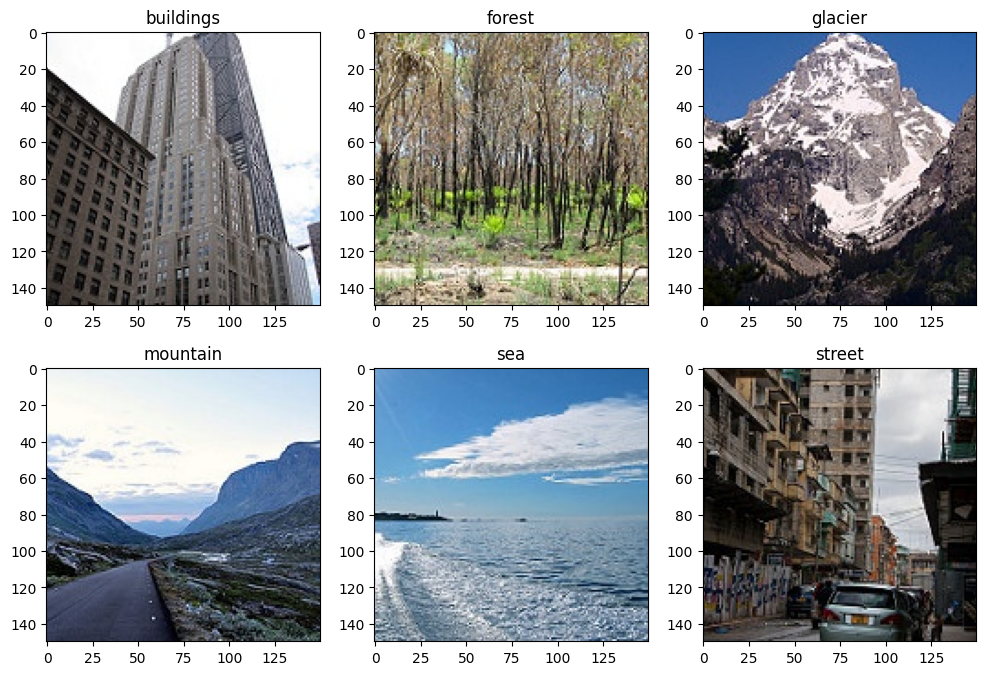

In [ ]:
def show_image(ax, image):
    img_paths = glob.glob(f"{train_path}{image}/*")
    i = np.random.randint(len(img_paths))
    img = cv2.imread(img_paths[i])
    ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    ax.set_title(image)

fig, ax = plt.subplots(2, 3, figsize=(12, 8))
image_categories = list(train_dict.keys())
show_image(ax[0, 0], 'buildings')
show_image(ax[0, 1], 'forest')
show_image(ax[0, 2], 'glacier')
show_image(ax[1, 0], 'mountain')
show_image(ax[1, 1], 'sea')
show_image(ax[1, 2], 'street')

Define the data generators for training, validation and test datasets.

In [ ]:
image_shape = (150,150,3)

batch_size = 128

training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=.20,
  )

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
  )

train_gen = training_datagen.flow_from_directory(train_path, target_size=image_shape[:2], color_mode='rgb', batch_size=batch_size, class_mode='categorical', subset='training')
valid_gen = training_datagen.flow_from_directory(train_path, target_size=image_shape[:2], color_mode='rgb', batch_size=batch_size, class_mode='categorical', subset='validation')
test_gen = test_datagen.flow_from_directory(test_path, target_size=image_shape[:2], color_mode='rgb', batch_size=batch_size, class_mode='categorical')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


## Custom Deep learning architecture training

Define a simple Convolutional Neural Network (CNN) model designed for image classification using TensorFlow. It consists of several layers, including convolutional layers with increasing numbers of filters, max-pooling layers for downsampling, fully connected layers with ReLU activations, dropout layers for regularization, and a final softmax activation layer for multi-class classification.

In [ ]:
model = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation="relu", input_shape=(150, 150, 3)),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation="relu"),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation="relu"),
    tf.keras.layers.MaxPool2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(256, kernel_regularizer=tf.keras.regularizers.l2(1e-5), activation="relu"),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(128, kernel_regularizer=tf.keras.regularizers.l2(1e-5), activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(64, kernel_regularizer=tf.keras.regularizers.l2(1e-5), activation="relu"),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(6, activation="softmax")
])

model.build((None, 150, 150, 3))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 74, 74, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 36, 36, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 34, 34, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 17, 17, 128)       0

The following cell sets up the Adam optimizer, a popular optimization algorithm, and the Categorical Crossentropy loss function, which is commonly used for multi-class classification tasks

In [ ]:
optimizer = tf.keras.optimizers.Adam()
loss = tf.keras.losses.CategoricalCrossentropy()

model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Define an early stopping callback for monitoring the validation accuracy during model training. The "monitor" parameter specifies that it should observe the validation accuracy, and the "mode" is set to 'max', indicating that it will stop training when the validation accuracy stops improving

In [ ]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=10)

Set the number of epochs to train the model, and start training, storing the training history in `hist`

In [ ]:
hist = model.fit(
    train_gen,
    epochs=25,
    verbose=1,
    callbacks=[es],
    validation_data=valid_gen
    ).history

Epoch 1/25
88/88 [==============================] - 108s 1s/step - loss: 1.3343 - accuracy: 0.4573 - val_loss: 1.1280 - val_accuracy: 0.5478
Epoch 2/25
88/88 [==============================] - 86s 979ms/step - loss: 1.0792 - accuracy: 0.5810 - val_loss: 0.9525 - val_accuracy: 0.6327
Epoch 3/25
88/88 [==============================] - 86s 983ms/step - loss: 0.9559 - accuracy: 0.6398 - val_loss: 0.8136 - val_accuracy: 0.7040
Epoch 4/25
88/88 [==============================] - 96s 1s/step - loss: 0.8658 - accuracy: 0.6878 - val_loss: 0.7529 - val_accuracy: 0.7340
Epoch 5/25
88/88 [==============================] - 102s 1s/step - loss: 0.7826 - accuracy: 0.7226 - val_loss: 0.7130 - val_accuracy: 0.7632
Epoch 6/25
88/88 [==============================] - 111s 1s/step - loss: 0.7414 - accuracy: 0.7436 - val_loss: 0.6789 - val_accuracy: 0.7710
Epoch 7/25
88/88 [==============================] - 88s 997ms/step - loss: 0.7138 - accuracy: 0.7516 - val_loss: 0.6363 - val_accuracy: 0.7764
Epoch 8/

Plot the training and validation accuracy and loss curves to see how the model has improved during training

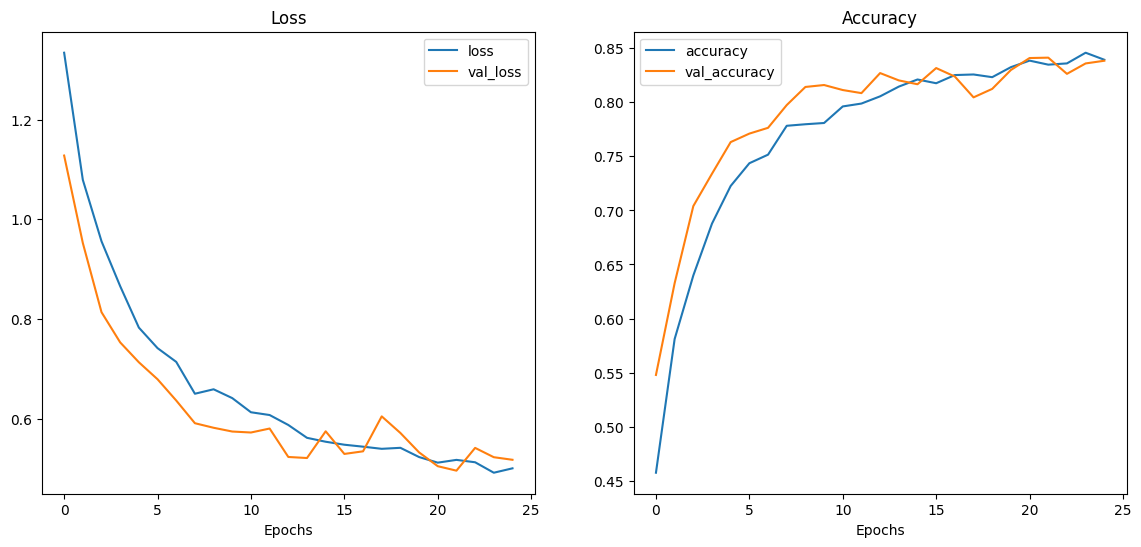

In [ ]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
pd.DataFrame(model.history.history)[['loss','val_loss']].plot(ax = ax[0])
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
pd.DataFrame(model.history.history)[['accuracy','val_accuracy']].plot(ax = ax[1])
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs');

### Evaluate and save the model

Evaluate the model on the test dataset and print the test accuracy

In [ ]:
loss, accuracy = model.evaluate(test_gen)

24/24 [==============================] - 19s 800ms/step - loss: 0.5098 - accuracy: 0.8373


Save the model in directory format

In [ ]:
model.save("intel_images_cnn")

Compress the model

In [ ]:
os.system("zip -r intel_images_cnn.zip intel_images_cnn")

0

Copy compressed model directory to drive

In [ ]:
!cp intel_images_cnn.zip /content/drive/MyDrive

# Transfer learning with MobileNetV2



In this code cell, a MobileNetV2 pre-trained model from TensorFlow's applications is loaded with weights pre-trained on ImageNet data. The model is configured to exclude the top classification layer. A new set of layers is added on top of MobileNetV2's output, including flattening, a dense layer with 64 units and ReLU activation, and batch normalization for regularization. The final output layer with softmax activation is attached to create a new transfer learning model.

In [8]:
image_shape = (224,224,3)

batch_size = 128

training_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=.20,
  )

test_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rotation_range=25,
    width_shift_range=0.1,
    rescale=1/255,
    shear_range=0.1,
    height_shift_range=0.2,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
  )

train_gen = training_datagen.flow_from_directory(train_path, target_size=image_shape[:2], color_mode='rgb', batch_size=batch_size, class_mode='categorical', subset='training')
valid_gen = training_datagen.flow_from_directory(train_path, target_size=image_shape[:2], color_mode='rgb', batch_size=batch_size, class_mode='categorical', subset='validation')
test_gen = test_datagen.flow_from_directory(test_path, target_size=image_shape[:2], color_mode='rgb', batch_size=batch_size, class_mode='categorical')

Found 11230 images belonging to 6 classes.
Found 2804 images belonging to 6 classes.
Found 3000 images belonging to 6 classes.


In [10]:
mobilenet_v2 = tf.keras.applications.MobileNetV2(weights='imagenet', include_top=False, input_shape=image_shape)

x = mobilenet_v2.output
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(64, activation='relu')(x)
x = tf.keras.layers.BatchNormalization()(x)
output = tf.keras.layers.Dense(6, activation='softmax')(x)

tl_model = tf.keras.Model(inputs=mobilenet_v2.input, outputs=output)
tl_model.build((None, 224, 224, 3))
tl_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 Conv1 (Conv2D)              (None, 112, 112, 32)         864       ['input_2[0][0]']             
                                                                                                  
 bn_Conv1 (BatchNormalizati  (None, 112, 112, 32)         128       ['Conv1[0][0]']               
 on)                                                                                              
                                                                                                  
 Conv1_relu (ReLU)           (None, 112, 112, 32)         0         ['bn_Conv1[0][0]']      

The following cell sets up the Adam optimizer with a very small learning rate and the Categorical Crossentropy loss function.

In [11]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss = tf.keras.losses.CategoricalCrossentropy()

tl_model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

Define an early stopping callback

In [12]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', mode='max', patience=5)

Set the number of epochs to train the model, and start training, storing the training history in `hist`

In [13]:
hist = tl_model.fit(
    train_gen,
    validation_data=test_gen,
    epochs=10,
    callbacks=[es]
    )

Epoch 1/10
88/88 [==============================] - 251s 2s/step - loss: 0.5030 - accuracy: 0.8260 - val_loss: 1.0303 - val_accuracy: 0.7430
Epoch 2/10
88/88 [==============================] - 205s 2s/step - loss: 0.2689 - accuracy: 0.9059 - val_loss: 0.5885 - val_accuracy: 0.8113
Epoch 3/10
88/88 [==============================] - 205s 2s/step - loss: 0.2185 - accuracy: 0.9196 - val_loss: 0.6647 - val_accuracy: 0.8133
Epoch 4/10
88/88 [==============================] - 206s 2s/step - loss: 0.1847 - accuracy: 0.9335 - val_loss: 0.4997 - val_accuracy: 0.8397
Epoch 5/10
88/88 [==============================] - 204s 2s/step - loss: 0.1547 - accuracy: 0.9435 - val_loss: 0.5004 - val_accuracy: 0.8393
Epoch 6/10
88/88 [==============================] - 200s 2s/step - loss: 0.1315 - accuracy: 0.9535 - val_loss: 0.5500 - val_accuracy: 0.8360
Epoch 7/10
88/88 [==============================] - 199s 2s/step - loss: 0.1157 - accuracy: 0.9577 - val_loss: 0.5073 - val_accuracy: 0.8523
Epoch 8/10
88

Plot the training and validation accuracy and loss curves to see how the model has improved during training

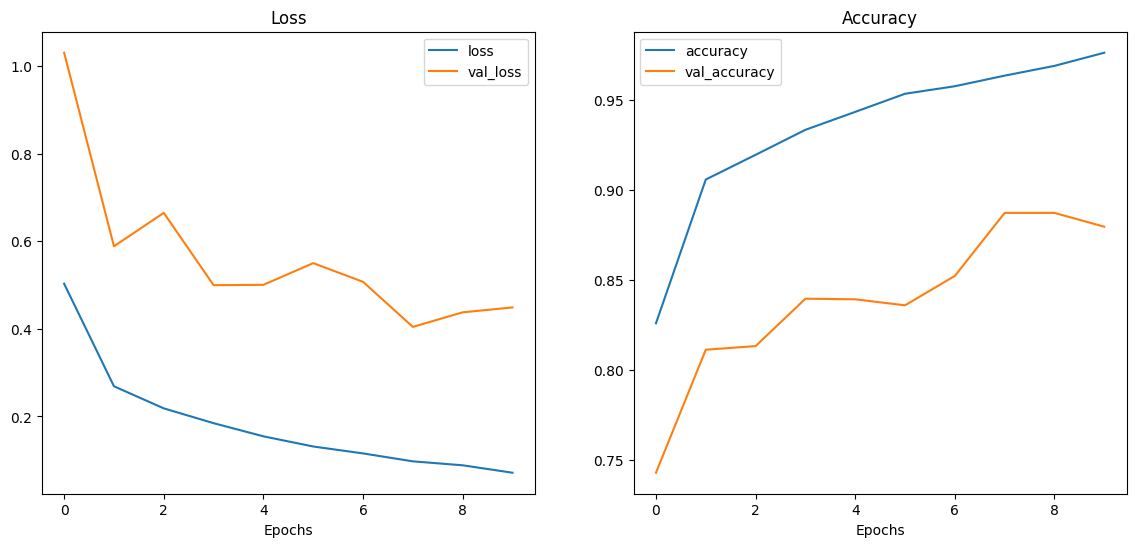

In [14]:
fig, ax = plt.subplots(1,2, figsize=(14,6))
pd.DataFrame(tl_model.history.history)[['loss','val_loss']].plot(ax = ax[0])
ax[0].set_title('Loss')
ax[0].set_xlabel('Epochs')
pd.DataFrame(tl_model.history.history)[['accuracy','val_accuracy']].plot(ax = ax[1])
ax[1].set_title('Accuracy')
ax[1].set_xlabel('Epochs');

### Evaluate and save the model

Evaluate the model on the test dataset and print the test accuracy

In [15]:
loss, accuracy = tl_model.evaluate(test_gen)

24/24 [==============================] - 39s 2s/step - loss: 0.4491 - accuracy: 0.8817


Save the model in directory format

In [17]:
tl_model.save("intel_images_mobileNetV2")

Compress the model

In [18]:
os.system("zip -r intel_images_mobileNetV2.zip intel_images_mobileNetV2")

0

Copy compressed model directory to drive

In [19]:
!cp intel_images_mobileNetV2.zip /content/drive/MyDrive